# Clustering de Estilos de Lanzamiento

La idea de este notebook, es identificar patrones en los lanzadores, para poder predecir el estilo de lanzamiento de un lanzador en base a sus estadísticas promedio. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

## 1. Carga y Preparación de Datos

Cargamos los datos y filtramos para quedarnos solo con lanzadores que tengan una muestra significativa de lanzamientos.

In [ ]:
cols_to_load = ['player_name', 'pitch_type', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'zone']

try:
    df_2023 = pd.read_csv('../data/statcast_raw_data/statcast_2023.csv', usecols=cols_to_load)
    df_2024 = pd.read_csv('../data/statcast_raw_data/statcast_2024.csv', usecols=cols_to_load)
    df = pd.concat([df_2023, df_2024], axis=0)
    print(f"Datos cargados: {df.shape}")
except FileNotFoundError:
    print("Error: No se encontraron los archivos de datos crudos.")

# Limpieza básica
df = df.dropna(subset=['release_speed', 'release_spin_rate', 'pitch_type'])

# Filtrar pitchers con pocos lanzamientos (ej: menos de 100)
pitcher_counts = df['player_name'].value_counts()
active_pitchers = pitcher_counts[pitcher_counts > 100].index
df = df[df['player_name'].isin(active_pitchers)]

print(f"Pitchers analizados: {len(active_pitchers)}")

Datos cargados: (1534286, 7)
Pitchers analizados: 938


## 2. Agregación por Pitcher

Para hacer clustering de *personas* (pitchers), necesitamos una fila por persona. Calcularemos:
1.  Velocidad promedio (`avg_speed`)
2.  Tasa de giro promedio (`avg_spin`)
3.  Movimiento horizontal y vertical promedio (`avg_pfx_x`, `avg_pfx_z`)
4.  Porcentaje de uso de Rectas (`fastball_pct`) vs Rompientes (`breaking_pct`).

In [ ]:
# Definir grupos de lanzamientos
fastballs = ['FF', 'SI', 'FC'] # Four-Seam, Sinker, Cutter
breaking = ['SL', 'CU', 'ST', 'SV'] # Slider, Curve, Sweeper, Slurve
offspeed = ['CH', 'FS', 'FO'] # Changeup, Splitter, Forkball

def get_pitch_mix(x):
    counts = x.value_counts(normalize=True)
    fb = counts[counts.index.isin(fastballs)].sum()
    br = counts[counts.index.isin(breaking)].sum()
    off = counts[counts.index.isin(offspeed)].sum()
    return pd.Series([fb, br, off], index=['fastball_pct', 'breaking_pct', 'offspeed_pct'])

# Agrupar
pitcher_stats = df.groupby('player_name').agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'std', # Variabilidad del movimiento horizontal
    'pfx_z': 'std'  # Variabilidad del movimiento vertical
}).rename(columns={'release_speed': 'avg_speed', 'release_spin_rate': 'avg_spin', 'pfx_x': 'std_pfx_x', 'pfx_z': 'std_pfx_z'})

pitch_mix = df.groupby('player_name')['pitch_type'].apply(get_pitch_mix).unstack()

pitcher_features = pd.concat([pitcher_stats, pitch_mix], axis=1).fillna(0)
print(pitcher_features.head())

                avg_speed     avg_spin  std_pfx_x  std_pfx_z  fastball_pct  \
player_name                                                                  
Abad, Fernando  87.507910  2120.299435   0.631508   0.621731      0.677966   
Abbott, Andrew  88.188181  2370.194221   0.850511   0.622079      0.519896   
Abbott, Cory    88.352774  2331.065434   0.567312   0.984101      0.459459   
Abreu, Albert   93.273661  2130.140474   0.665376   0.384784      0.577700   
Abreu, Bryan    91.442266  2667.521804   0.673168   0.909739      0.446888   

                breaking_pct  offspeed_pct  
player_name                                 
Abad, Fernando      0.000000      0.158192  
Abbott, Andrew      0.316201      0.163667  
Abbott, Cory        0.068279      0.000000  
Abreu, Albert       0.273924      0.148376  
Abreu, Bryan        0.550130      0.002982  


## 3. Clustering (K-Means)

Normalizamos los datos y aplicamos K-Means para encontrar grupos naturales.

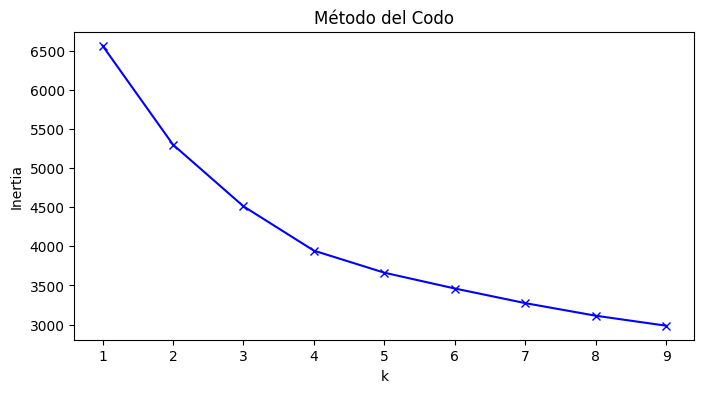

In [ ]:
# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitcher_features)

# Método del Codo para encontrar K óptimo
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.show()

In [ ]:
# Aplicar K-Means con K=4 (ejemplo, ajustar según el gráfico del codo)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

pitcher_features['cluster'] = clusters

# Analizar los clusters
print("Promedios por Cluster:")
cluster_summary = pitcher_features.groupby('cluster').mean()
print(cluster_summary)

# Definir arquetipos basados en las características dominantes
def define_archetype(cluster_id):
    stats = cluster_summary.loc[cluster_id]
    
    if stats['avg_speed'] > cluster_summary['avg_speed'].mean() + cluster_summary['avg_speed'].std() * 0.5:
        return "Power Pitchers"
    elif stats['breaking_pct'] > cluster_summary['breaking_pct'].mean() + cluster_summary['breaking_pct'].std() * 0.5:
        return "Breaking Ball Specialists"
    elif stats['std_pfx_x'] < cluster_summary['std_pfx_x'].mean() - cluster_summary['std_pfx_x'].std() * 0.5:
        return "Control Artists"
    else:
        return "Balanced Pitchers"

archetypes = {i: define_archetype(i) for i in range(k)}
# Crear nombres completos para la tabla de resumen
archetypes_full = {i: f"Cluster {i}: {define_archetype(i)}" for i in range(k)}
pitcher_features['archetype'] = pitcher_features['cluster'].map(archetypes)

print("\n" + "="*50)
print("ARQUETIPOS IDENTIFICADOS:")
print("="*50)
for cluster_id, archetype in archetypes_full.items():
    print(f"\n{archetype}")
    print(f"  - Velocidad promedio: {cluster_summary.loc[cluster_id, 'avg_speed']:.1f} mph")
    print(f"  - Spin promedio: {cluster_summary.loc[cluster_id, 'avg_spin']:.0f} rpm")
    print(f"  - % Rectas: {cluster_summary.loc[cluster_id, 'fastball_pct']*100:.1f}%")
    print(f"  - % Rompientes: {cluster_summary.loc[cluster_id, 'breaking_pct']*100:.1f}%")
    print(f"  - % Cambios: {cluster_summary.loc[cluster_id, 'offspeed_pct']*100:.1f}%")

Promedios por Cluster:
         avg_speed     avg_spin  std_pfx_x  std_pfx_z  fastball_pct  \
cluster                                                               
0        87.901555  2077.377317   0.678980   0.592750      0.503109   
1        88.362065  2322.716345   0.995743   0.462130      0.540492   
2        89.154745  2364.711488   0.630480   0.782556      0.499433   
3        91.389004  2230.912920   0.661247   0.546759      0.705891   

         breaking_pct  offspeed_pct  
cluster                              
0            0.207295      0.265329  
1            0.383838      0.073062  
2            0.421384      0.065131  
3            0.182637      0.088933  


## 4. Visualización (PCA)

Reducimos la dimensionalidad a 2 componentes principales para visualizar los clusters en un plano 2D.

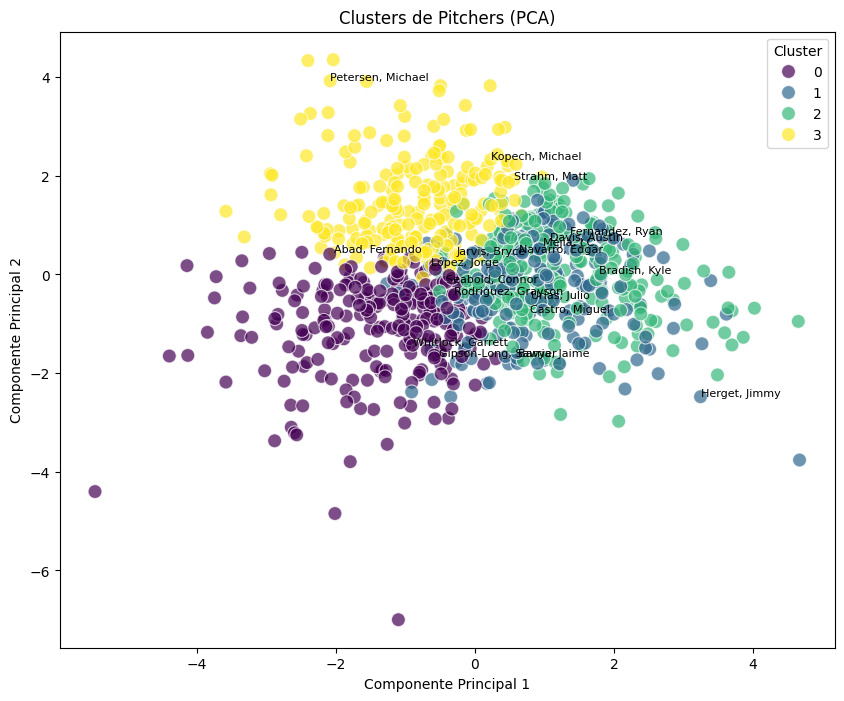

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obtener la varianza explicada por cada componente
var_explained = pca.explained_variance_ratio_

# Crear el gráfico mejorado
plt.figure(figsize=(14, 10))

# Crear un color map personalizado para los arquetipos
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_colors = {i: colors[i] for i in range(k)}

# Plotear los puntos por cluster
for cluster_id in range(k):
    mask = pitcher_features['cluster'] == cluster_id
    archetype_name = archetypes[cluster_id]  # Ya no necesita replace
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=cluster_colors[cluster_id], 
               label=archetype_name,
               s=120, alpha=0.6, edgecolors='black', linewidth=0.5)

# Anotar los centroides
centroids_pca = pca.transform(kmeans.cluster_centers_)
for i, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0], centroid[1], 
               c=cluster_colors[i], 
               s=500, alpha=0.8, 
               edgecolors='black', linewidth=3, marker='*')
    archetype_name = archetypes[i]  # Ya no necesita replace
    plt.annotate(f'★ {archetype_name}', 
                xy=(centroid[0], centroid[1]), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=cluster_colors[i], alpha=0.7))

# Anotar algunos pitchers representativos
for i, txt in enumerate(pitcher_features.index):
    if i % 80 == 0:  # Reducir aún más para no saturar
        plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), 
                    fontsize=7, alpha=0.7)

# Mejorar etiquetas de los ejes con varianza explicada
plt.xlabel(f'Componente Principal 1 ({var_explained[0]*100:.1f}% varianza explicada)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({var_explained[1]*100:.1f}% varianza explicada)', 
          fontsize=12, fontweight='bold')

plt.title('Arquetipos de Pitchers identificados mediante K-Means Clustering\n(Reducción dimensional con PCA)', 
         fontsize=14, fontweight='bold', pad=20)

plt.legend(title='Arquetipos de Lanzadores', fontsize=11, title_fontsize=12, 
          loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Mostrar qué representa cada componente principal
print("\n" + "="*60)
print("INTERPRETACIÓN DE COMPONENTES PRINCIPALES")
print("="*60)
print(f"\nVarianza total explicada: {var_explained.sum()*100:.1f}%")
print(f"  - PC1 explica: {var_explained[0]*100:.1f}% de la varianza")
print(f"  - PC2 explica: {var_explained[1]*100:.1f}% de la varianza")

print("\nContribución de cada variable a los componentes:")
feature_names = pitcher_features.columns[:-2]  # Excluir 'cluster' y 'archetype'
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)
print(components_df.round(3))